In [37]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from aerobot.io import RESULTS_PATH, load_results_dict
import os
from typing import Dict, List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Some specs to make plots look nice. 
TITLE_FONT_SIZE, LABEL_FONT_SIZE = 10, 8
PALETTE = 'Paired'
# Set all matplotlib global parameters.
plt.rc('font', **{'family':'sans-serif', 'sans-serif':['Arial'], 'size':LABEL_FONT_SIZE})
plt.rc('xtick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('ytick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('axes',  **{'titlesize':TITLE_FONT_SIZE, 'labelsize':LABEL_FONT_SIZE})
# plt.rcParams['image.cmap'] = 'Paired'
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Paired.colors)

In [38]:
# TODO: Work this in to the io.py module. Also add other feature types. 
PRETTY_NAMES = {'KO':'All gene families', 'embedding.geneset.oxygen':'Five-gene set', 'chemical':'Chemical features', 'nt_1mer': 'NT counts', 'aa_1mer':'AA counts'}
PRETTY_NAMES.update({'embedding.genome':'Genome embedding', 'metadata':'Metadata'})
PRETTY_NAMES.update({f'nt_{i}mer':f'NT {i}-mers' for i in range(2, 6)})
PRETTY_NAMES.update({f'cds_{i}mer':f'CDS {i}-mers' for i in range(1, 6)})
PRETTY_NAMES.update({f'aa_{i}mer':f'AA {i}-mers' for i in range(2, 4)})
PRETTY_NAMES

{'KO': 'All gene families',
 'embedding.geneset.oxygen': 'Five-gene set',
 'chemical': 'Chemical features',
 'nt_1mer': 'NT counts',
 'aa_1mer': 'AA counts',
 'embedding.genome': 'Genome embedding',
 'metadata': 'Metadata',
 'nt_2mer': 'NT 2-mers',
 'nt_3mer': 'NT 3-mers',
 'nt_4mer': 'NT 4-mers',
 'nt_5mer': 'NT 5-mers',
 'cds_1mer': 'CDS 1-mers',
 'cds_2mer': 'CDS 2-mers',
 'cds_3mer': 'CDS 3-mers',
 'cds_4mer': 'CDS 4-mers',
 'cds_5mer': 'CDS 5-mers',
 'aa_2mer': 'AA 2-mers',
 'aa_3mer': 'AA 3-mers'}

In [39]:
# For coloring the annotated and unannotated feature types differently. 
ANNOTATED = ['KO', 'embedding.geneset.oxygen', 'embedding.genome'] 
UNANNOTATED = ['chemical', 'aa_1mer', 'aa_3mer']
FEATURE_TYPES = UNANNOTATED + ANNOTATED  # A minimal list of feature types. 

## Loading results

In [40]:
# NOTE: showing phylogenetic bias for nonlinear models. 
phylo_bias_results = {}
phylo_bias_results['KO'] = load_results_dict(os.path.join(RESULTS_PATH, 'phylo_bias', 'phylo_bias_results_nonlinear_KO.json'))
phylo_bias_results['aa_3mer'] = load_results_dict(os.path.join(RESULTS_PATH, 'phylo_bias', 'phylo_bias_results_nonlinear_aa_3mer.json'))
#phylo_bias_results['nt_5mer'] = load_results_dict(os.path.join(RESULTS_PATH, 'phylo_bias', 'phylo_bias_results_nonlinear_nt_5mer.json'))


In [41]:
phylo_bias_results['aa_3mer'].keys()

dict_keys(['scores', 'weight_decay', 'n_epochs', 'hidden_dim', 'alpha', 'lr', 'batch_size', 'early_stopping', 'n_classes', 'input_dim', 'feature_type', 'model_class', 'binary'])

In [42]:
# Load in the results of each training run. 
nonlinear_results = dict() # Results of Nonlinear classifier. 
logistic_results = dict() # Results of LogisticRegression-based classifier. 

for feature_type in FEATURE_TYPES:
    filename = f'run_results_nonlinear_{feature_type}.json'
    nonlinear_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, 'run', filename))
    filename = f'run_results_logistic_{feature_type}.json'
    logistic_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, 'run', filename))

## Figure 1

In [43]:
def plot_figure_1a(grid:GridSpec=None, fig:plt.Figure=None):
    '''Just a placeholder, the diagram describing annotation-ful versus annotation-free pipelines for
    predicting metabolism will go here.'''
    ax = fig.add_subplot(grid)
    ax.set_axis_off()
    #ax.set_visible(False)

In [44]:
def plot_figure_1b(nonlinear_results:Dict, logistic_results:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot comparing Nonlinear and Logistic ternary classifier performance on the holdout set.'''

    def _format_barplot_axes(ax:plt.Axes):
        random_baseline =  0.33 # Expected performance for random classifier on task. 
        # Label bins with the feature name. 
        ax.set_xticks(np.arange(0, len(FEATURE_TYPES), 1), [PRETTY_NAMES[f] for f in FEATURE_TYPES], rotation=45, ha='right')

        # Set up left y-axis with the balanced accuracy information. 
        ax.set_ylabel('balanced validation accuracy')
        ax.set_ylim(0, 1.02)
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1)) # xmax is the number to divide by for the percentage.
        # Add a second set of y-ticks on the right to indicate percentage performance increase over random (33% accurate)
        #new_ax = ax.twinx()
        #new_ax.set_ylim(0, 1)
        #yticks = np.round(100 * (np.arange(0, 1.1, 0.1) - random_baseline) / random_baseline, 0)
        #ytick_labels = [f'{v:.0f}%' for v in yticks]
        #new_ax.set_yticks(yticks, ytick_labels)
        #new_ax.set_ylabel('percent above random')

        # Add horizontal line marking model performance with random classification. 
        ax.axhline(random_baseline, color='grey', linestyle='--', linewidth=2, zorder=-10)
        #ax.set_title('B', loc='left', fontweight='bold')

    ax = fig.add_subplot(grid)

    # Extract the final balanced accuracies on from the results dictionaries. 
    nonlinear_val_accs  = [nonlinear_results[feature_type]['validation_acc'] for feature_type in FEATURE_TYPES]
    logistic_val_accs  = [logistic_results[feature_type]['validation_acc'] for feature_type in FEATURE_TYPES]

    colors = ['tab:blue'] * len(ANNOTATED) + ['tab:green'] * len(UNANNOTATED)
    ax.bar(np.arange(0, len(FEATURE_TYPES), 1) - 0.2, logistic_val_accs, width=0.4, label='logistic', color=colors, edgecolor='k', linewidth=0.5, hatch='///')
    ax.bar(np.arange(0, len(FEATURE_TYPES), 1) + 0.2, nonlinear_val_accs, width=0.4, label='nonlinear', color=colors, edgecolor='k', linewidth=0.5)

    # # Custom legend. Colors indicate annotation-free or annotation-full, and hatching indicates training or validation set. 
    handles = [plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch='////')]
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch=''))
    # handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='tab:blue', edgecolor='k', linewidth=0.5))
    # handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='tab:green', edgecolor='k', linewidth=0.5))
    labels = ['linear', 'nonlinear']
    plt.legend(handles, labels, ncol=2, fontsize=7, columnspacing=0.3, handletextpad=0.3, loc='upper left', bbox_to_anchor=(0.01, 0.99))
    # plt.legend(handles, labels, ncol=2, fontsize=7, columnspacing=0.3, handletextpad=0.3, loc='upper left', bbox_to_anchor=(0.25, 0.99))

    _format_barplot_axes(ax)


In [45]:
def plot_figure_1c(phylo_bias_results:Dict, grid:GridSpec=None, fig:plt.Figure=None, show_points:bool=True):
    '''Plots the results of a single run of phlogenetic bias analysis''' 
    ax = fig.add_subplot(grid)
    
    #feature_type = phylo_bias_results['feature_type'] # Extract the feature type from the results dictionary. 
    levels = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'][::-1]

    # Load in results for the baselines. 
    randrel_results = load_results_dict(os.path.join(RESULTS_PATH, 'phylo_bias', 'phylo_bias_results_randrel.json'))
    meanrel_results = load_results_dict(os.path.join(RESULTS_PATH, 'phylo_bias', 'phylo_bias_results_meanrel.json'))

    colors = ['black', 'tab:blue']
    
    #res = [meanrel_results, randrel_results, phylo_bias_results]
    #res = [randrel_results, phylo_bias_results]
    for i, (fs_key, results) in enumerate(phylo_bias_results.items()):
        if results is not None:
            # Plot the error bar, as well as scatter points for each level. 
            means = [results['scores'][level]['mean'] for level in levels] # Extract the mean F1 scores.
            errs = [results['scores'][level]['err'] for level in levels] # Extract the standard errors. 
            level_scores = [results['scores'][level]['scores'] for level in levels] # Extract the raw scores for each level. 
            # Convert the scores to points for a scatter plot. 
            scores_x = np.ravel([np.repeat(i + 1, len(s)) for i, s in enumerate(level_scores)])
            scores_y = np.ravel(level_scores)

            label = PRETTY_NAMES[fs_key]
            ax.errorbar(np.arange(1, len(levels) + 1), means, yerr=errs, c=colors[i], ls='-', capsize=3, label=label)
        
            if show_points: # Only show the points if specified.
                ax.scatter(scores_x, scores_y, color=colors[i], s=3)
            

    ax.set_ylabel('balanced accuracy on holdout')
    ax.set_ylim(0, 1.02)
    ax.set_xticks(np.arange(1, len(levels) + 1), labels=levels, rotation=45, ha='right')
    ax.set_xlabel('holdout level')
    #ax.set_title('phylo. generalization')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1)) # xmax is the number to divide by for the percentage.
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    random_baseline =  0.33
    ax.axhline(random_baseline, color='grey', linestyle='--', linewidth=2, zorder=-10)

    new_ax = ax.twinx()
    yticks = np.round(100 * (np.arange(0, 1.1, 0.2) - random_baseline) / random_baseline, 0)
    ytick_labels = [f'{v:.0f}%' for v in yticks]
    new_ax.set_yticks(yticks, ytick_labels)
    new_ax.set_ylabel('percent above random')
    ax.legend()


/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_41666/3553224960.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


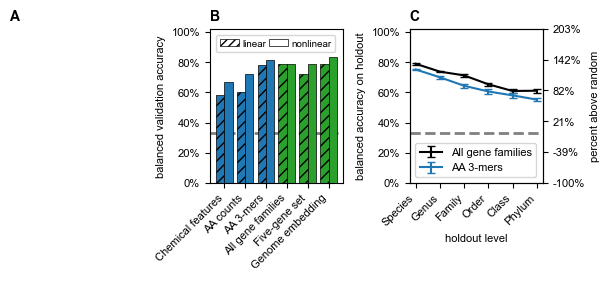

In [46]:
fig = plt.figure(figsize=(6.875, 2))
grid = GridSpec(1, 3, wspace=0.5) 

plot_figure_1a(grid=grid[0, 0], fig=fig)
# mark linear/nonlinear and annotation/annotation-free on the plot.
plot_figure_1b(nonlinear_results, logistic_results, grid=grid[0, 1], fig=fig)
plot_figure_1c(phylo_bias_results, grid=grid[0, 2], fig=fig, show_points=False)

for panel_label, ax in zip('ABC', fig.get_axes()):
    ax.set_title(panel_label, loc='left', fontweight='bold')

plt.tight_layout()
plt.show()

In [47]:
logistic_df = pd.DataFrame(logistic_results)
logistic_df.loc['validation_acc']

chemical                    0.582782
aa_1mer                     0.604927
aa_3mer                     0.784091
KO                          0.789814
embedding.geneset.oxygen    0.719947
embedding.genome            0.785096
Name: validation_acc, dtype: object

In [48]:
nonlinear_df = pd.DataFrame(nonlinear_results)
nonlinear_df.loc['validation_acc']

chemical                    0.670286
aa_1mer                     0.722969
aa_3mer                     0.814438
KO                          0.789821
embedding.geneset.oxygen    0.785615
embedding.genome            0.831122
Name: validation_acc, dtype: object

In [49]:
phylo_bias_df = pd.DataFrame(phylo_bias_results)
phylo_bias_df['mean_score'] = phylo_bias_df.scores.apply(lambda x: x['mean'])

order = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
phylo_bias_df.loc[order, 'mean_score']


AttributeError: 'DataFrame' object has no attribute 'scores'